In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import truncnorm

### Functions for Gibbs sampling (given y = 1)

In [2]:
def sample_trunc(s1, s2, sigma_t):
    loc = s1 - s2
    scale = sigma_t
    myclip_a = 0
    myclip_b = np.Inf
    a, b = (myclip_a - loc) / scale, np.inf
    return stats.truncnorm.rvs(a, b, loc, scale)

def multiGaussian(mu_s, sigma_s, t):
    
    A = np.array([[1,-1]])
    sigma_ts = 1
    
    sigma_st = (np.add(sigma_s.I, 1/sigma_ts * A.T @ A)).I
    mu_st = sigma_st @ (np.add(sigma_s.I @ mu_s, 1/sigma_ts * A.T * t))
    return stats.multivariate_normal.rvs(np.ravel(mu_st), sigma_st)

def gibbs(s1_0, s2_0, sigma_t, sigma_s, n):
    samples_s1 = []
    samples_s2 = []
    s1 = s1_0
    s2 = s2_0
    mu_s = np.array([[0], [0]])
    for i in range(n):
        t = sample_trunc(s1, s2, sigma_t)
        s1,s2 = multiGaussian(mu_s, sigma_s, t)
        samples_s1.append(s1)
        samples_s2.append(s2)
    return samples_s1,samples_s2

### Run the Gibbs sampler for one match (y = 1)

In [3]:
sigma_t = 1
sigma_s0 = 1

s1_0 = 0
s2_0 = 0

sigma_s = np.matrix(
    [[sigma_s0,0],
     [0,sigma_s0]])

s1,s2 = gibbs(s1_0, s2_0, sigma_t, sigma_s, 150)

### Try to determine the burn-in period

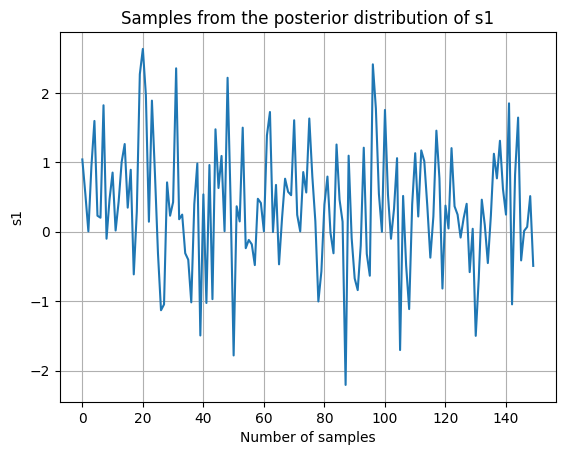

In [4]:
plt.plot(s1)
plt.grid()
plt.xlabel("Number of samples")
plt.ylabel("s1")
plt.title("Samples from the posterior distribution of s1")
plt.show()

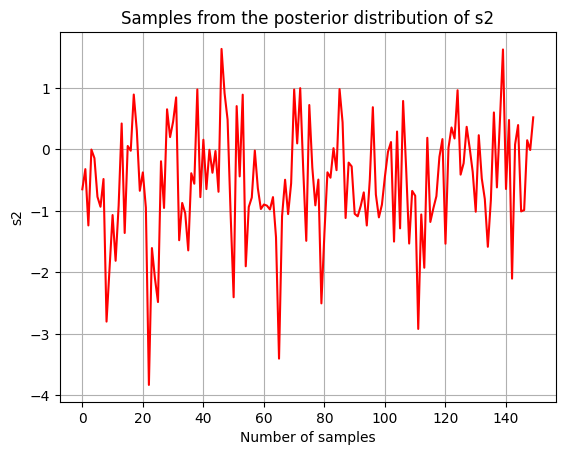

In [5]:
plt.plot(s2, c='r')
plt.grid()
plt.xlabel("Number of samples")
plt.ylabel("s2")
plt.title("Samples from the posterior distribution of s2")
plt.show()

In [6]:
s1,s2= gibbs(s1_0, s2_0, sigma_t, sigma_s, 300)

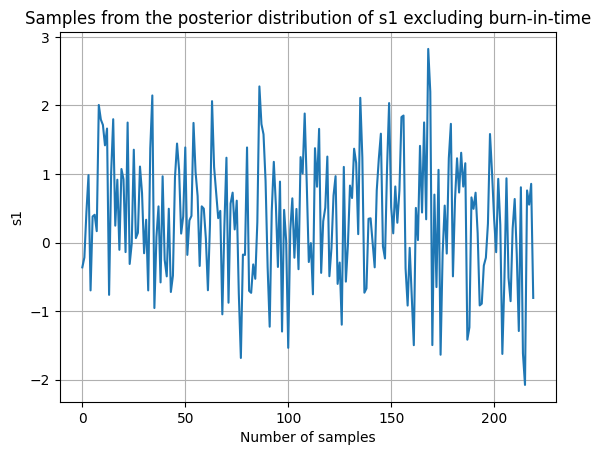

In [7]:
# New plots excluding BURNIN=80
burn=80
s1_exB = s1[burn:]
s2_exB = s2[burn:]
plt.plot(s1_exB)
plt.grid()
plt.xlabel("Number of samples")
plt.ylabel("s1")
plt.title("Samples from the posterior distribution of s1 excluding burn-in-time")
plt.show()

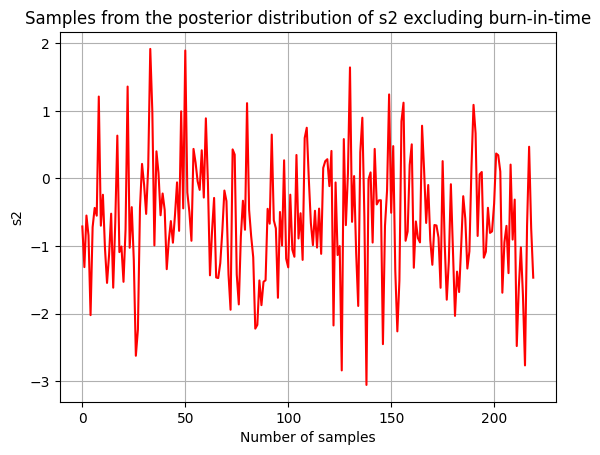

In [8]:
plt.plot(s2_exB, c='r')
plt.grid()
plt.xlabel("Number of samples")
plt.ylabel("s2")
plt.title("Samples from the posterior distribution of s2 excluding burn-in-time")
plt.show()

### Find a Gaussian approximation of the posterior distributions

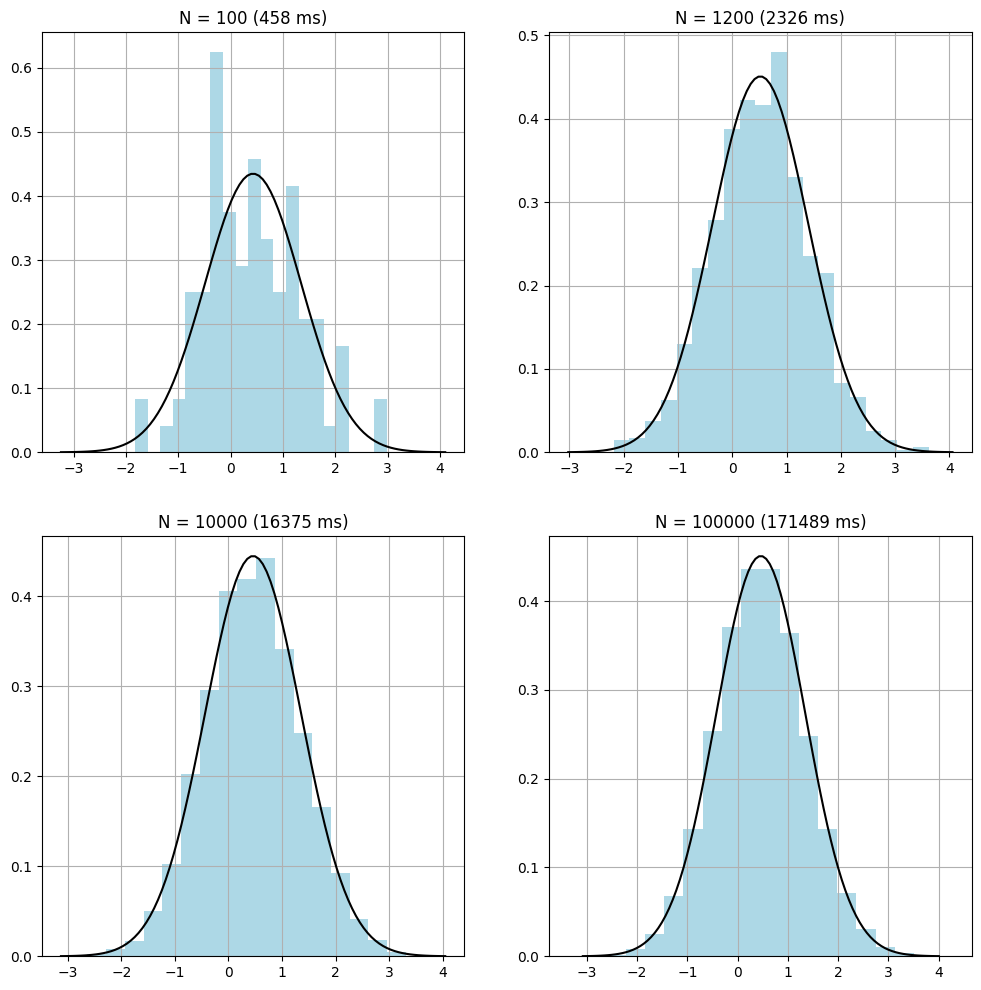

In [9]:
BURN_IN = 80
#N_SAMPLES = [10**2, 10**4 , 10**5 , 10**6]  # Excluding burn-in
N_SAMPLES = [10**2, 1200 , 10**4 , 10**5] 

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i in range(len(N_SAMPLES)):  

    # Perform the sampling (including burn-in)
    t0 = time.time()
    s1, s2 = gibbs(s1_0, s2_0, sigma_t, sigma_s, BURN_IN + N_SAMPLES[i])
    t = int((time.time() - t0) * 1000)

    # Discard burn-in samples 
    s1 = s1[BURN_IN:]

    # Calculate the parameters of the approximated pdf
    s1_mean = np.mean(s1)
    s1_std = np.std(s1)
    
    # Plot the approximated pdf together with the histograms of the samples
    x = np.linspace(s1_mean - s1_std * 4, s1_mean + s1_std * 4, 100)
    y = stats.norm.pdf(x, loc=s1_mean, scale=s1_std)
    axs[i // 2, i % 2].set_title("N = " + str(N_SAMPLES[i]) + " (" + str(t) + " ms)")
    axs[i // 2, i % 2].plot(x, y, c='black')
    axs[i // 2, i % 2].hist(s1, bins=20, density=True, color='lightblue')
    axs[i // 2, i % 2].grid()

plt.show()

### Comparison of prior and posterior skill distributions

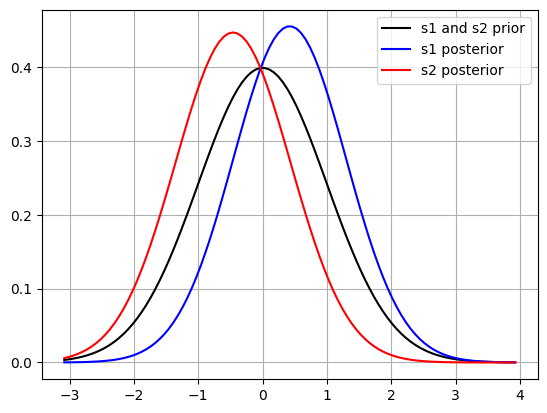

In [10]:
BURN_IN = 80
N_SAMPLES = 1200

# Perform the sampling (including burn-in)
s1, s2 = gibbs(s1_0, s2_0, sigma_t, sigma_s, BURN_IN + N_SAMPLES)

# Discard burn-in samples 
s1 = s1[BURN_IN:]
s2 = s2[BURN_IN:]

# Calculate the parameters of the approximated pdfs
s1_mean = np.mean(s1)
s1_std = np.std(s1)
s2_mean = np.mean(s2)
s2_std = np.std(s2)
    
# Plot the pdfs
x = np.linspace(s1_mean - s1_std * 4, s1_mean + s1_std * 4, 100)
plt.plot(x, stats.norm.pdf(x, loc=s1_0, scale=sigma_s0), label="s1 and s2 prior", c="black")
plt.plot(x, stats.norm.pdf(x, loc=s1_mean, scale=s1_std), label="s1 posterior", c="blue")
plt.plot(x, stats.norm.pdf(x, loc=s2_mean, scale=s2_std), label="s2 posterior", c="red")
plt.grid()
plt.legend()
plt.show()

## Q6 - Q7

#### relevant functions are defined in the below hidden cell to preserve readability and prevent code reuse throughout Q6-Q11

In [11]:
def load_nhl_data():
    """Load the NHL data set from a CSV file."""
    data = pd.read_csv('nhl_data.csv')
    data["yyyy-mm-dd"]=data["Date"]
    data['year'] = data['yyyy-mm-dd'].apply(lambda x: int(x.split('-')[0]))
    data['year+month']=data['yyyy-mm-dd'].apply(lambda x: int(x.split('-')[0])*100+int(x.split('-')[1]))
    data = data.loc[(data["year+month"]>=201808) & (data["year+month"]<=201907)]
    #data = data.loc[data["year"]==2020]
    data['team1']=data['Home_Team_Name']
    data["team2"]=data["Away_Team_Name"]
    data["score1"]=data["Home_Score"]
    data["score2"]=data["Away_Score"]

    return data[["yyyy-mm-dd","team1","team2","score1","score2"]]

def load_serieA_data():
    """Load the Serie A data set from a CSV file."""
    data = pd.read_csv('SerieA.csv')
    data.drop("HH:MM", axis=1, inplace=True)
    return data

In [12]:
#new
def sample_trunc_modified(s1, s2, y, sigma_ts,eps,draws=False):
    if not draws:
        lower, upper = (0, np.inf) if y == 1 else (-np.inf, 0)
    else:
        lower, upper = (eps, np.inf) if y == 1 else (-np.inf, -eps) if y==-1 else (-eps, eps)
    loc = s1 - s2
    scale = sigma_ts
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return stats.truncnorm.rvs(a, b, loc, scale)

def multiGaussian_modified(mu_s, sigma_s, t, sigma_ts):
    
    A = np.array([[1, -1]])
    
    sigma_st = (np.add(sigma_s.I, 1/sigma_ts * A.T @ A)).I
    mu_st = sigma_st @ (np.add(sigma_s.I @ mu_s, 1/sigma_ts * A.T * t))
    return stats.multivariate_normal.rvs(np.ravel(mu_st), sigma_st)

def gibbs_modified(mu_1, mu_2, var1, var2, sigma_ts, y, n,eps):
    
    samples_s1 = []
    samples_s2 = []
    
    sigma_s = np.matrix(
    [[var1, 0],
     [0, var2]])
    
    mu_s = np.array([[mu_1], [mu_2]])
    
    s1 = np.random.normal(mu_1, var1)
    s2 = np.random.normal(mu_2, var2)
    
    for i in range(n):
        t = sample_trunc_modified(s1, s2, y, sigma_ts,eps)
        s1, s2 = multiGaussian_modified(mu_s, sigma_s, t, sigma_ts)
        samples_s1.append(s1)
        samples_s2.append(s2)
    return samples_s1,samples_s2



In [13]:
def process_data(data,draws=False,shuffle=False):
    #remove draws or not
    if not draws:
        data = data.loc[data["score1"] != data["score2"]]
    
    #create result column
    data['result'] = data.apply(lambda x: 1 if x.score1 > x.score2 else -1 if x.score2>x.score1 else 0, axis = 1)

    data = data.reset_index(drop = True)
    if shuffle:
        data = data.sample(frac=1)
        data.reset_index(inplace=True,drop=True)
    
    teams = data[['team1']]
    teams = pd.unique(data["team1"])
    team_stats = pd.DataFrame({'team': teams, 'mean':0, 'variance':1})
    return data,team_stats
    


In [14]:
def pred_y(mu_1, mu_2, var_1, var_2, sigma_ts,eps,draws=False):
    
    sigma_s = np.matrix(
    [[var_1, 0],
     [0, var_2]])

    mu_s = np.array([[mu_1], [mu_2]])
    A = np.array([[1, -1]])
    
    est_mu_t = A @ mu_s
    est_sigma_t = sigma_ts + A @ sigma_s @ A.T
    
    if not draws:
        p = 1 - stats.norm.cdf(0, est_mu_t, est_sigma_t)[0][0]   # The probability that t > 0 (i.e., that team 1 wins)
        return 1 if p > 0.5 else -1 
    else:
        p_p1_loss = stats.norm.cdf(-eps, est_mu_t, est_sigma_t)[0][0]
        p_p1_win = 1 - stats.norm.cdf(eps, est_mu_t, est_sigma_t)[0][0] > 0.5
        p_draw = 1 - p_p1_loss - p_p1_win 
        p_max = max([p_p1_loss,p_p1_win,p_draw])   
        return 1 if p_p1_win == p_max else -1 if p_p1_loss == p_max else 0

In [15]:
def run_model(matches,team_stats,BURN_IN,N_SAMPLES,draws=False):
    sigma_ts = 1
    prediction_list = []
    eps = 0.25 

    predictions = []
    eps_list = []
    for i in range(len(matches)):
        team_1 = matches.iloc[i]["team1"]
        team_2 = matches.iloc[i]["team2"]
        y = matches.iloc[i]["result"] # y=1 or y=-1

        # Extract average and variance for each team
        mu_1 = team_stats[team_stats["team"] == team_1][["mean"]].values[0][0] 
        var_1 = team_stats[team_stats["team"] == team_1][["variance"]].values[0][0] 
        mu_2 = team_stats[team_stats["team"] == team_2][["mean"]].values[0][0] 
        var_2 = team_stats[team_stats["team"] == team_2][["variance"]].values[0][0] 
        
        # Prediction
        prediction = pred_y(mu_1, mu_2, var_1, var_2, sigma_ts,eps,draws)
        predictions.append(y == prediction)
        
        # Perform the sampling (burn-in included)
        s1_samples, s2_samples = gibbs_modified(mu_1, mu_2, var_1, var_2, sigma_ts, y, BURN_IN + N_SAMPLES,eps)
        
        # Discard burn-in samples 
        s1_samples = s1_samples[BURN_IN:]
        s2_samples = s2_samples[BURN_IN:]
        
        mu_1 = np.mean(s1_samples)
        mu_2 = np.mean(s2_samples)
        var_1 = np.var(s1_samples)
        var_2 = np.var(s2_samples)
        
        # Update average and variance for each team
        team_1_index = team_stats.index[team_stats['team'] == team_1].tolist()[0]
        team_2_index = team_stats.index[team_stats['team'] == team_2].tolist()[0]
        team_stats.loc[team_1_index, 'mean'] = mu_1
        team_stats.loc[team_2_index, 'mean'] = mu_2
        team_stats.loc[team_1_index, 'variance'] = var_1
        team_stats.loc[team_2_index, 'variance'] = var_2
        
        if y != prediction:
            if y == 0:
                #tie, guessed other
                #increase eps
                eps += eps*0.1
                
            elif prediction == 0:
                #guessed tie, not correct
                #decrease eps
                eps -= eps*0.1
        
    matches["predictions"] = predictions  
    preds = matches["predictions"].to_numpy().tolist()
    print(team_stats.sort_values("mean"))
    print("----------------------------------")
    print("Accuracy:", (np.sum(preds) / len(preds)).round(2))
    return team_stats

## Process and predict matches in SerieA

In [16]:
data = load_serieA_data()
data,team_stats=process_data(data)

result = run_model(data,team_stats,80,300)

C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\137204986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['result'] = data.apply(lambda x: 1 if x.score1 > x.score2 else -1 if x.score2>x.score1 else 0, axis = 1)


          team      mean  variance
0       Chievo -1.353993  0.121212
17   Frosinone -0.874798  0.069320
11       Genoa -0.449809  0.113985
3     Sassuolo -0.434692  0.089880
14       Parma -0.392521  0.071776
19    Cagliari -0.382659  0.070917
10     Udinese -0.377812  0.044322
12  Fiorentina -0.313452  0.087574
9         Spal -0.290883  0.052769
4       Empoli -0.269842  0.118413
5      Bologna -0.115731  0.083064
15   Sampdoria -0.102314  0.080837
1        Lazio  0.144037  0.061576
18        Roma  0.359397  0.081024
2       Torino  0.409676  0.050348
16       Inter  0.523108  0.042061
13       Milan  0.529969  0.062868
6     Atalanta  0.704258  0.077619
8       Napoli  0.907698  0.061505
7     Juventus  1.141762  0.104057
----------------------------------
Accuracy: 0.66


C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\3762838443.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


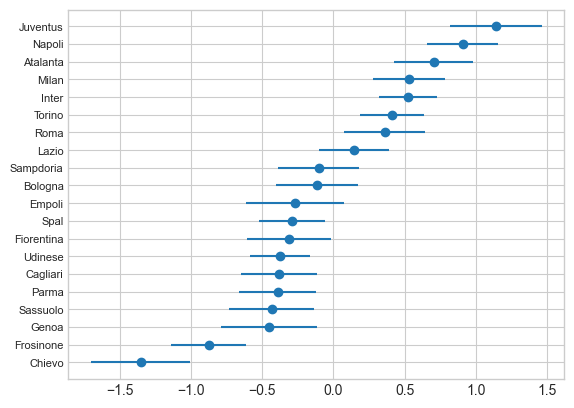

In [17]:
plt.style.use('seaborn-whitegrid')
result = result.sort_values("mean")
x = result["team"]
y = result["mean"]
x_error = np.sqrt(result["variance"])
plt.errorbar(y,x,
             xerr = x_error,
             fmt ='o')
plt.yticks(fontsize=8)
plt.show()

## Shuffle SerieA-data before process and predict

In [18]:
data = load_serieA_data()
data,team_stats=process_data(data,shuffle=True)

result = run_model(data,team_stats,80,300)

C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\137204986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['result'] = data.apply(lambda x: 1 if x.score1 > x.score2 else -1 if x.score2>x.score1 else 0, axis = 1)


          team      mean  variance
5       Chievo -1.219227  0.183124
1    Frosinone -0.856230  0.090306
19  Fiorentina -0.492098  0.087898
17    Cagliari -0.381816  0.071097
3       Empoli -0.335174  0.049681
7        Genoa -0.290556  0.079190
8         Spal -0.239216  0.077399
10       Parma -0.192557  0.056222
12     Udinese -0.165241  0.063571
13     Bologna -0.031459  0.091208
9     Sassuolo -0.022100  0.090374
18   Sampdoria  0.223421  0.049392
4        Lazio  0.293992  0.056920
14    Atalanta  0.384547  0.071555
15      Torino  0.428020  0.096595
16       Inter  0.527481  0.091344
6         Roma  0.600139  0.056947
11       Milan  0.656872  0.077297
2       Napoli  0.990208  0.074409
0     Juventus  1.236829  0.067973
----------------------------------
Accuracy: 0.66


C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\3762838443.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


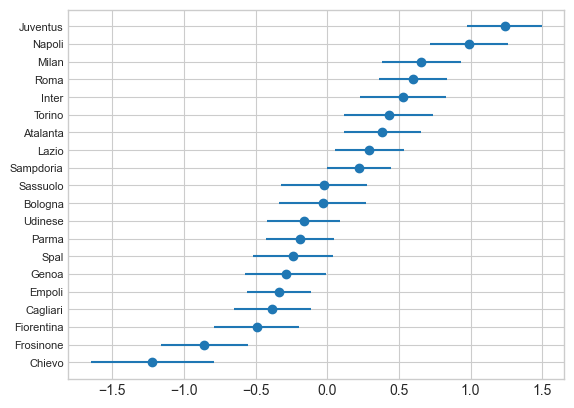

In [19]:
plt.style.use('seaborn-whitegrid')
result = result.sort_values("mean")
x = result["team"]
y = result["mean"]
x_error = np.sqrt(result["variance"])
plt.errorbar(y,x,
             xerr = x_error,
             fmt ='o')
plt.yticks(fontsize=8)
plt.show()

## Q10. NHL-data 2018-2019 season

In [20]:

data = load_nhl_data()
data,team_stats=process_data(data)

result = run_model(data,team_stats,80,300)

                     team      mean  variance
9        New York Rangers -0.415974  0.033338
10        Ottawa Senators -0.406167  0.011070
15      Los Angeles Kings -0.380058  0.007960
19      New Jersey Devils -0.294767  0.022773
23          Anaheim Ducks -0.294303  0.017909
8       Detroit Red Wings -0.259543  0.035847
26    Philadelphia Flyers -0.255620  0.014610
28       Florida Panthers -0.215887  0.017838
22     Chicago Blackhawks -0.214103  0.021163
18         Minnesota Wild -0.174208  0.010671
30        Edmonton Oilers -0.147421  0.020529
6      Colorado Avalanche -0.126599  0.019335
4          Buffalo Sabres -0.120143  0.005203
2       Vancouver Canucks -0.103083  0.012635
16        Arizona Coyotes -0.053131  0.014865
11    Pittsburgh Penguins  0.027528  0.022846
7            Dallas Stars  0.029171  0.014299
17         Calgary Flames  0.031885  0.022433
29     Montreal Canadiens  0.032521  0.008141
25    Nashville Predators  0.082802  0.014173
0         San Jose Sharks  0.08350

C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\3762838443.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


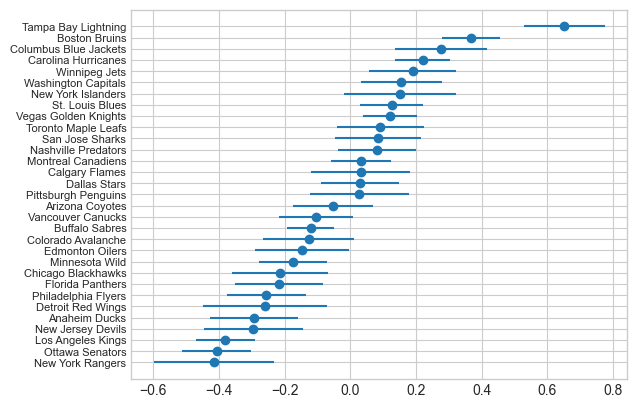

In [21]:
plt.style.use('seaborn-whitegrid')
result = result.sort_values("mean")
x = result["team"]
y = result["mean"]
x_error = np.sqrt(result["variance"])
plt.errorbar(y,x,
             xerr = x_error,
             fmt ='o')
plt.yticks(fontsize=8)
plt.show()

## Q11. Implementing draws

In [22]:
data = load_serieA_data()
data,team_stats=process_data(data,draws=True)

result = run_model(data,team_stats,100,400,draws=True)

          team      mean  variance
0       Chievo -0.951040  0.043137
14   Frosinone -0.914157  0.076584
10        Spal -0.449020  0.031683
13       Genoa -0.389999  0.038408
4        Parma -0.386217  0.039636
3     Sassuolo -0.383446  0.058499
5       Empoli -0.333760  0.045195
16    Cagliari -0.235695  0.038641
11     Udinese -0.218714  0.037326
15  Fiorentina -0.116044  0.038690
6      Bologna -0.074918  0.054255
19   Sampdoria  0.087086  0.056284
1        Lazio  0.111441  0.049094
12       Inter  0.348736  0.063238
17        Roma  0.406362  0.037813
7     Atalanta  0.516731  0.036682
9       Napoli  0.524559  0.037056
18       Milan  0.591486  0.040432
2       Torino  0.730173  0.038452
8     Juventus  0.755149  0.064657
----------------------------------
Accuracy: 0.49


C:\Users\Tobbe\AppData\Local\Temp\ipykernel_3376\3762838443.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


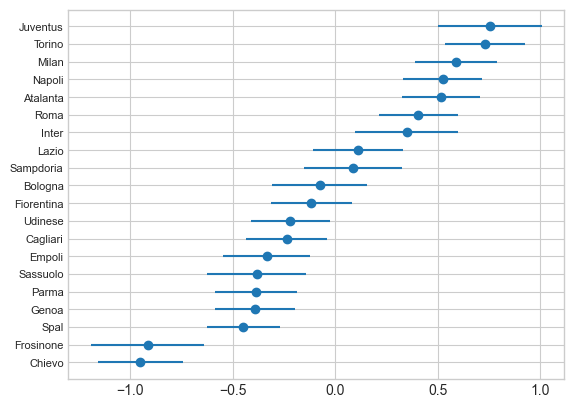

In [23]:
plt.style.use('seaborn-whitegrid')
result = result.sort_values("mean")
x = result["team"]
y = result["mean"]
x_error = np.sqrt(result["variance"])
plt.errorbar(y,x,
             xerr = x_error,
             fmt ='o')
plt.yticks(fontsize=8)
plt.show()

## Q9 Message passing

In [24]:
def multiplyGauss(m1, s1, m2, s2):
    
    s = 1/(1/s1+1/s2)
    m = (m1/s1+m2/s2)*s
    return m, s

def divideGauss(m1, s1, m2, s2):
    
    m,s = multiplyGauss(m1, s1, m2, -s2)
    return m, s

def truncGaussMM(a, b, m0, s0):
    
    # a,b interval on which gaussian is being truncated [a,b]
    # m0,s0: mean and variance of the Gaussian which is to be truncated
    
    a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    
    return m, s

In [25]:
m0_s1 = 0 # Mean prior of p(s1)
s0_s1 = 1 # The variance of the prior p(s1)
m0_s2 = 0 # Mean prior of p(s2)
s0_s2 = 1 # The variance of the prior p(s2)

sv = 1 # The variance of p(t|s), where s = {s1, s2}
y0 = 1

mu_1_m = m0_s1 
mu_1_s = s0_s1

mu_3_m = mu_1_m
mu_3_s = mu_1_s

mu_2_m = m0_s2
mu_2_s = s0_s2

mu_4_m = mu_2_m
mu_4_s = mu_2_s

mu_5_m = mu_4_m
mu_5_s = mu_3_s + mu_4_s + sv

# mu_6 and mu_7

if y0 == 1:
    a,b = 0, np.inf
else:
    a,b = -np.inf, 0

pt_m, pt_s = truncGaussMM(a, b, mu_5_m, mu_5_s)

mu_8_m, mu_8_s = divideGauss(pt_m, pt_s, mu_5_m, mu_5_s)

mu_9_m, mu_9_s = (mu_8_m + mu_2_m), sv + mu_8_s + mu_2_s
mu_10_m, mu_10_s = (mu_1_m - mu_8_m), sv + mu_8_s + mu_1_s

s1_final = multiplyGauss(mu_9_m, mu_9_s, m0_s1, s0_s1)
s2_final = multiplyGauss(mu_10_m, mu_10_s, m0_s2, s0_s2)

s1_final_mean = s1_final[0]
s1_final_var = s1_final[1]
s2_final_mean = s2_final[0]
s2_final_var = s2_final[1]

print(s1_final_mean, s1_final_var)
print(s2_final_mean, s2_final_var)

0.4606588659617806 0.7877934092108061
-0.4606588659617806 0.7877934092108061


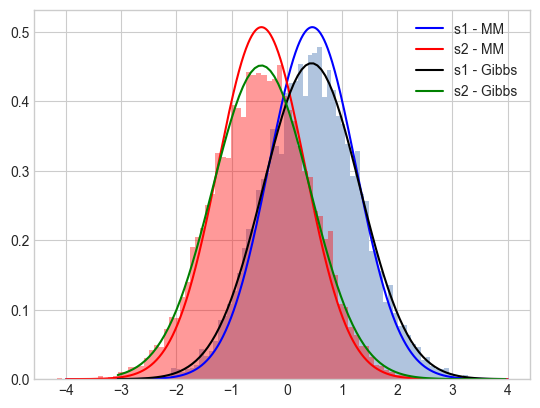

In [26]:
s1,s2 = gibbs(s1_0, s2_0, sigma_t, sigma_s, 10000)

# Calculate the parameters of the approximated pdfs
s1_mean = np.mean(s1)
s1_std = np.std(s1)
s2_mean = np.mean(s2)
s2_std = np.std(s2)
    
# Plot the pdfs
x = np.linspace(s1_mean - s1_std * 4, s1_mean + s1_std * 4, 100)

x_datapoints = np.linspace(-4,4,1000)
plt.plot(x_datapoints, stats.norm.pdf(x_datapoints, loc=s1_final_mean, scale=s1_final_var), label="s1 - MM", c="blue")
plt.plot(x_datapoints, stats.norm.pdf(x_datapoints, loc=s2_final_mean, scale=s2_final_var), label="s2 - MM", c="red")
plt.plot(x, stats.norm.pdf(x, loc=s1_mean, scale=s1_std), label="s1 - Gibbs", c="black")
plt.plot(x, stats.norm.pdf(x, loc=s2_mean, scale=s2_std), label="s2 - Gibbs", c="green")
plt.hist(s1, bins = 80, density = True, color = "lightsteelblue")
plt.hist(s2, bins = 80, density = True, alpha = 0.4, color = "red")
plt.legend()
plt.show()